# Advanced Lane Finding
---

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply the distortion correction to the raw image.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find lane boundary.
6. Determine curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---


In [1]:
#Import everything needed for the project

import numpy as np
import cv2
import pickle
import glob, os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import misc
from scipy.misc import imresize
import math


# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


In [2]:
#contants
#chessboard 
nx = 9
ny = 6

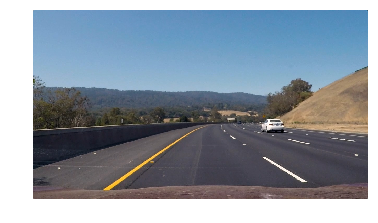

In [3]:
#Image to perform test on
#image = mpimg.imread('test_images/straight_lines2.jpg')
image = mpimg.imread('test_images/test3.jpg')
image_size = image.shape
plt.imshow(image);
plt.axis('off');


In [4]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x or y
    if orient == "x":
        sobelxy = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        
    if orient == "y":
        sobelxy = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        
    abssxy = np.absolute(sobelxy) # Absolute xy derivative to accentuate strong verticalish lines
    scale_factor = np.max(abssxy)/255 # Will use this to scale back to 8-bit scale
    abssxy = (abssxy/scale_factor).astype(np.uint8) #rescaling to 8-bit 

    # Threshold xy gradient
    retval, sxybinary = cv2.threshold(abssxy, thresh[0], thresh[1], cv2.THRESH_BINARY)

    return sxybinary

def mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100)):
    # Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 

    
    retval, mag_binary = cv2.threshold(gradmag, mag_thresh[0], mag_thresh[1], cv2.THRESH_BINARY)
    
    return mag_binary

def dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.4)):
    
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # To avoid error messages due to diving by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
        
    return dir_binary

def rgb2hls(img, thresh=(0, 255)):    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    # Threshold color channel
    retval, s_binary = cv2.threshold(s.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)
    

    
    return s_binary




# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [5]:
def show_images(images,row,col, title):
        
    #Split the figure in x rows and y columns to put images
    figure, axes = plt.subplots(row,col, figsize=(24, 9))

    # hspace vertical space reserve for white space between subplots
    # wspace horizontal space reserve for white space between subplots
    figure.subplots_adjust(hspace=0.1)
    
    for i, ax in enumerate(axes.flat):
        image_shape = np.shape(images[i])
        ax.imshow(images[i].reshape(image_shape), cmap='gray')

        #ax.set_xticks([])
        #ax.set_yticks([])
        index = i +1
        msg = str("Test %g"%index + "_%s"%title)
        ax.set_title(msg)
        
    plt.subplots_adjust(left=0., right=0.4, top=0.9, bottom=0.)

    plt.show()

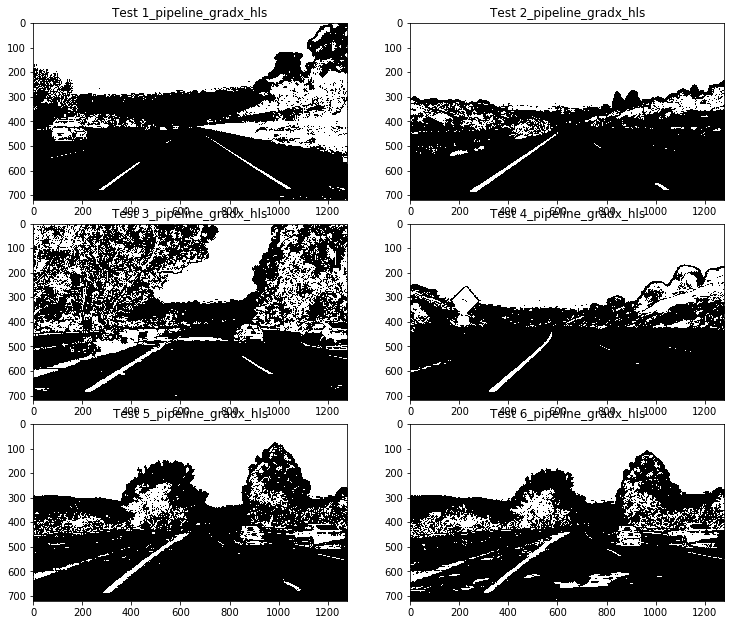

In [6]:
# Plot the result   
n_row = 3
n_col =2

def pipeline_gradx_hls(img):
    img = np.copy(img)

    #HLS
    s_binary= hls_select(img, thresh=(80, 255))
    
   
    # Gradient x
    sxbinary = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(200, 250))

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    #color_binary = np.dstack(( np.zeros_like(sxbinary),sxbinary, s_binary))
    combined_binary = np.clip(cv2.bitwise_or(s_binary, sxbinary), 0, 1).astype('uint8')
    
    return combined_binary
    
images_filtered =[]
images = glob.glob('test_images/*.jpg')
for idx, image_name in enumerate(images):
    name = image_name.split('/')
    img =  mpimg.imread(image_name)
    filtered= pipeline_gradx_hls(img)
    images_filtered.append(filtered)

show_images(images_filtered,n_row,n_col,"pipeline_gradx_hls")

In [7]:
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "calibration/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

In [8]:
def undistortion(img, mtx, dist):
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undst

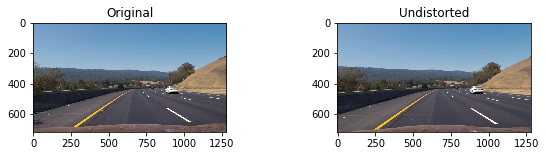

In [9]:
#Test undistortion function
image_undis = undistortion(image,mtx,dist)
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.imshow(image)
#plt.axis('off');
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(image_undis)
plt.title('Undistorted')
#plt.axis('off');

In [10]:
#Function to obtain a warped image

def warp(img, src, dst):  
        
    #Get the perspective transform.
    M = cv2.getPerspectiveTransform(src, dst)
    Minv =  cv2.getPerspectiveTransform(dst, src)
    
    #Warp an image using the perspective transform (M)
    warped = cv2.warpPerspective(img, M, (image_size[1],image_size[0]),  flags=cv2.INTER_LINEAR)   
    

    return warped, M, Minv

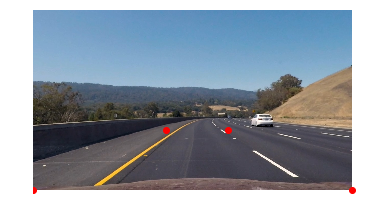

In [11]:
horizon = np.uint(2*image_size[0]/3)
bottom = np.uint(image_size[0])
center_lane = np.uint(image_size[1]/2)
offset = 20

x_left_bottom = 0
x_right_bottom = 2*center_lane
x_right_upper = center_lane +  center_lane/4.5
x_left_upper = center_lane + offset - center_lane/5


source = np.float32([[x_left_bottom,bottom],[x_right_bottom,bottom],[x_right_upper,horizon],[x_left_upper,horizon]])

destination = np.float32([[0,image_size[0]],[image_size[1],image_size[0]],
                  [image_size[1],0],[0,0]])


plt.imshow(image_undis)
plt.plot(x_left_bottom,bottom,'ro')
plt.plot(x_right_bottom,bottom,'ro')
plt.plot(x_right_upper,horizon,'ro')
plt.plot(x_left_upper,horizon,'ro');
plt.axis('off');


In [12]:
#Test warp function with image
warped, M, Minv =  warp(image_undis,source,destination)


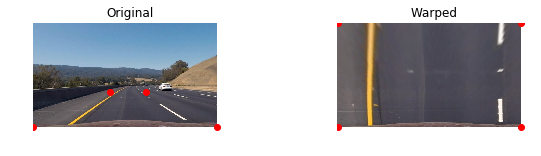

In [13]:
#Test warp function
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.imshow(image_undis)
plt.axis('off');
plt.title('Original')
plt.plot(x_left_bottom,bottom,'ro')
plt.plot(x_right_bottom,bottom,'ro')
plt.plot(x_right_upper,horizon,'ro')
plt.plot(x_left_upper,horizon,'ro')

#Test warp function
plt.subplot(1,2,2)
plt.imshow(warped)
plt.title('Warped')
plt.axis('off')
plt.plot(0,image_size[0],'ro')
plt.plot(image_size[1],image_size[0],'ro')
plt.plot(image_size[1],0,'ro')
plt.plot(0,0,'ro');


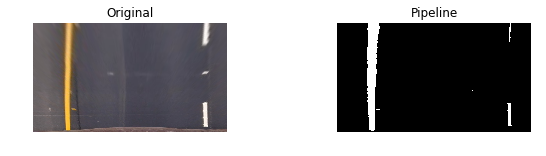

In [14]:
#Test pipeline in warped image
filtered= pipeline_gradx_hls(warped)

plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.imshow(warped)
plt.axis('off');
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(filtered, cmap='gray')
plt.title('Pipeline')
plt.axis('off');


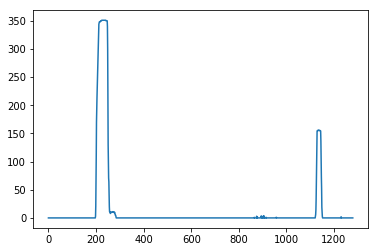

In [15]:
out = np.zeros(image.shape[1])
histogram = np.sum(filtered[image.shape[0]//2:,:], axis=0, out = out)
plt.plot(histogram);

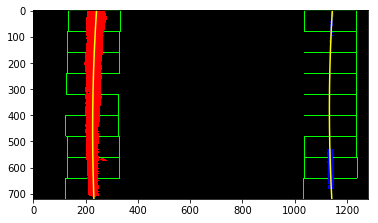

In [24]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return left_fitx, right_fitx, out_img


left_fitx, right_fitx, out_img = fit_polynomial(filtered)

plt.imshow(out_img)